# AutoICE - Future of Automatic Sea Ice Mapping 
This notebook will introduce you to the thematics and help explore and analyze the input and output data of the AutoICE challenge. It should be seen as a supplement to the challenge dataset manual and repeats some aspects. Two other notebooks are available, the quickstart and test_upload. The quickstart notebook contains an example of a pipeline to load the ready-to-train dataset, as well as training and testing of a 'simple' U-Net model. The test_upload notebook creates ice charts from the test scenes and compiles the output into a NetCDF file ready to upload to AI4EO.eu.

## Challenge context
Synthetic Aperture Radar (SAR) satellite images are used extensively for producing sea ice charts in support of Arctic navigation. However, due to ambiguities in the relationship between SAR backscatter and ice conditions (different ice types and concentrations, as well as different wind conditions over the ocean, have the same backscatter signature), the process of producing ice charts is done by manual interpretation of the satellite data taking into account also the texture patterns of the ice in the SAR images. The process is labour intensive and time-consuming, and thus, the amount of ice charts that are produced on a given day is limited. Automatically generated high-resolution sea ice maps have the potential to increase the use of satellite imagery in ice charting by providing more products and shorter time delays between acquisition and product availability. The design of an automatic and robust sea ice classification scheme has been studied for many years. Recent approaches to this issue that use Convolutional Neural Networks (i.e. image segmentation techniques) show promising results. This challenge aims to create AI systems that can exploit the spatial information of Sentinel-1 SAR images to map sea ice in the Arctic.

## Objective
Your task will be to map three sea ice parameters, the total Sea Ice Concentration (SIC), the Stage Of Development (SOD), and the floe size (FLOE). To successfully map these sea ice parameters, the AI4Arctic sea ice challenge dataset has been prepared. The AI4Arctic sea ice challenge dataset includes 493 training and 20 testing files in netCDF format. Each file contains: 
two-channel dual polarized (HH and HV) Sentinel-1 Extra Wide Swath (EW) images, auxiliary Sentinel-1 image parameters, microwave radiometer measurements from the AMSR2 sensor on board the JAXA GCOM-W satellite,
several Numerical Weather Prediction (NWP) parameters from the ERA5 reanalysis dataset, the corresponding ice chart based on that Sentinel-1 image, produced by either the Greenland Ice Service at DMI or the Canadian Ice Service (CIS).

Two versions of the dataset are available, the raw version and the ready-to-train version, to allow for both full experimentability and to quickly get started. In this notebook, only the ready-to-train version will be examined. The challenge dataset manual contains a more detailed explanation of the dataset. The dataset contains the following data variables:

In [48]:
# -- Built-in modules -- #
import os
os.environ['AI4ARCTIC_DATA'] = '/media/fernando/Databases/ai4arcticready2test'  # Fill in directory for data location.
os.environ['AI4ARCTIC_ENV'] = ''  # Fill in directory for environment with Ai4Arctic get-started package. 


# -- Third-part modules -- #
import xarray as xr
import numpy as np
scene_name = '20210506T075557_dmi_prep.nc'  # Scene from the challenge dataset manual. Change as you like.
scene = xr.open_dataset(os.path.join(os.environ['AI4ARCTIC_DATA'], scene_name))  # Open the scene.
scene  # Enable interactive exploration of the scene (below).

<xarray.Dataset>
Dimensions:               (sar_sample_2dgrid_points: 18,
                           sar_line_2dgrid_points: 21, sar_lines: 4234,
                           sar_samples: 5222, 2km_grid_lines: 169,
                           2km_grid_samples: 208)
Dimensions without coordinates: sar_sample_2dgrid_points,
                                sar_line_2dgrid_points, sar_lines, sar_samples,
                                2km_grid_lines, 2km_grid_samples
Data variables: (12/29)
    sar_grid2d_latitude   (sar_sample_2dgrid_points, sar_line_2dgrid_points) float64 ...
    sar_grid2d_longitude  (sar_sample_2dgrid_points, sar_line_2dgrid_points) float64 ...
    nersc_sar_primary     (sar_lines, sar_samples) float32 ...
    nersc_sar_secondary   (sar_lines, sar_samples) float32 ...
    sar_incidenceangle    (sar_lines, sar_samples) float32 ...
    distance_map          (sar_lines, sar_samples) float32 ...
    ...                    ...
    skt                   (2km_grid_lines, 2km_grid_samples) float32 ...
    tcwv                  (2km_grid_lines, 2km_grid_samples) float32 ...
    tclw                  (2km_grid_lines, 2km_grid_samples) float32 ...
    SIC                   (sar_lines, sar_samples) uint8 ...
    SOD                   (sar_lines, sar_samples) uint8 ...
    FLOE                  (sar_lines, sar_samples) uint8 ...
Attributes:
    scene_id:       20210506T075557_dmi_prep.nc
    original_id:    S1B_EW_GRDM_1SDH_20210506T075557_20210506T075648_026781_0...
    ice_service:    dmi
    flip:           1
    pixel_spacing:  80

In [49]:
global_meanstd = np.load(os.environ['AI4ARCTIC_ENV'] + 'misc/global_meanstd.npy', allow_pickle=True).item()
t2m = scene['t2m'].mean()*global_meanstd['t2m']['std'] + global_meanstd['t2m']['mean']
skt = scene['skt'].mean()*global_meanstd['skt']['std'] + global_meanstd['skt']['mean']
u10m = scene['u10m_rotated'].mean()*global_meanstd['u10m_rotated']['std'] + global_meanstd['u10m_rotated']['mean']
v10m = scene['v10m_rotated'].mean()*global_meanstd['v10m_rotated']['std'] + global_meanstd['v10m_rotated']['mean']

wind_speed = np.sqrt(u10m**2 + v10m**2) 
angle = np.arctan2(v10m, u10m) * 180/np.pi

print(f'T2M: {t2m.item()}')
print(f'SKT: {skt.item()}')
print(f'Wind Speed: {wind_speed.item()}')
print(f'Angle: {angle.item()}')

lat = scene['sar_grid2d_latitude'].mean().item()
long = scene['sar_grid2d_longitude'].mean().item()
print(f'Latitude: {lat}')
print(f'Longitude: {long}')


T2M: 269.3196444452879
SKT: 270.57346221326236
Wind Speed: 4.644599648106849
Angle: 46.1160249136516
Latitude: 69.9617151736128
Longitude: -17.83058602263176


- Sea ice chart parameters
    * 'SIC': The total SIC is the percentage ratio of sea ice to open-water for an area, discretised into 11 10%-bin classes ranging from 0% (open-water) to 100% (fully-covered sea ice). 
    * 'SOD': The SOD can also be viewed as the type of sea ice, which is a proxy for the thickness of the sea ice, i.e. how easy it is to traverse it. The parameter contains 5 classes, 0: Open-water, 1: New ice, 2: Young ice, 3: Thin First-year ice, 4: Thick First-year ice and 5: Old ice, i.e. older than 1 year.
    * 'FLOE': The floe size describe how large or continuous the sea ice pieces/chunks are, with 6 parameters: 0: Open-water, 1: Cake ice, 2: Small floe, 3: Medium floe, 4: Big floe, 5: Vast floe, and 6: Bergs, i.e. variants of icebergs and glacier ice.
- Geographical information
    * 'distance_map': A map over the distance from land for all Sentinel-1 pixels. A nonlinear translation from kilometers to land to an index has been carried out.
    * 'sar_2dgrid_latitude': Latitude of subgrid points in the scene (i.e. latitude/longitude per SAR pixel is not available).
    * 'sar_2dgrid_longitude': Longitude of subgrid points in the scene.
- Synthetic Aperture Radar
    * 'nersc_sar_primary': HH Polarization
    * 'nersc_sar_secondary': HV Polarization
    * 'sar_incidenceangle': inclination of the measurement angle from the instrument to the ground
- AMSR2 Passive Microwave Radiometer
    * 'btemp_6_9v': 6.9 GHz vertical polarization. Transferred to the Sentinel-1 image geometry.
    * 'btemp_6_9h': 6.9 GHz horizontal polarization.
    * ..
    * 'btemp_89h_0' : 89 GHz horizontal polarization.
- ERA5 Environmental Variables
    * 'u10m_rotated': ERA5 eastward component of the 10m wind rotated to account for the Sentinel-1 flight direction.
    * 'v10m_rotated': ERA5 northward component of the 10m wind rotated to account for the Sentinel-1 flight direction.
    * 't2m': ERA5 2m air temperature.
    * 'skt': ERA5 skin temperature.
    * 'tcwv': ERA5 total column water vapour.
    * 'tclw': ERA5 total column cloud liquid water. 

There is no requirement to use all the data variables.
There are three data grids to keep in mind in the dataset. The full grid containing the ice charts, distance map, SAR and auxiliary SAR variables. In connection to the SAR data, there is a grid with Ground Control Point (GCP) e.g. containing geographical location. Finally, there is the subgrid containing the AMSR2 and ERA5 environmental data.

## Preprocessing steps.
In the raw dataset, ice charts are stored in a 2darray containing ID numbers for polygons with an associated lookup table with ice information for each polygon. A polygon icechart conversion script is attached to do a similar conversion for the raw dataset. As the SOD and FLOE codes are given for partial sea ice concentrations, we utilize a threshold of 65% to indicate when a class is dominant in a polygon.

To reduce the barrier of entry and ease of working with the data, the original 40 m pixel spacing ($\sim$10,000 x 10,000 pixels) in the SAR (and charts etc.) data have been downsampled to 80 m ($\sim$5,000 x 5,000 pixels). It is also required to deliver icecharts in this pixel spacing. The SAR, distance map and incidence angle have been downsampled using a 2×2 averaging kernel, whereas ice charts are reduced with a 2x2 max kernel. This is followed by aligning the masks (nan-values) across the data (except the subgridded variables). Afterwards, the scenes are standard scaled using the mean and standard deviation of the values for each variable (z = (x - u) / s, where x are original values, u = mean and s = standard deviation). Minimum and maximum, and mean and std values for each variable are also available in the two files 'global_minmax.npy' and 'global_meanstd.npy', respectively.

Finally, NaN values in the SAR images are replaced with 0 and 255 in ice charts (stored as the largest value in uint8) to represent non-data or masked pixels. The chart fill value can be used to discount the relevant pixels during the loss calculation. Feel free to change these values or schemes. Below is an illustration of the different dataset parameters.

# Sea ice charts
Manual ice charting from multi-sensor satellite data analysis has for many years been the method applied at the National Ice Centers around the world for producing sea ice information for marine safety. Ice analysts primarily use SAR imagery due to the radar sensor's high resolution and capability to see through clouds and in polar darkness. The ice charts used in the AI4Arctic sea ice challenge dataset are from the Canadian (CIS)- and DMI operational ice services. The ice charts from the two ice services cover sub-regions of the Canadian and Greenland Waters.


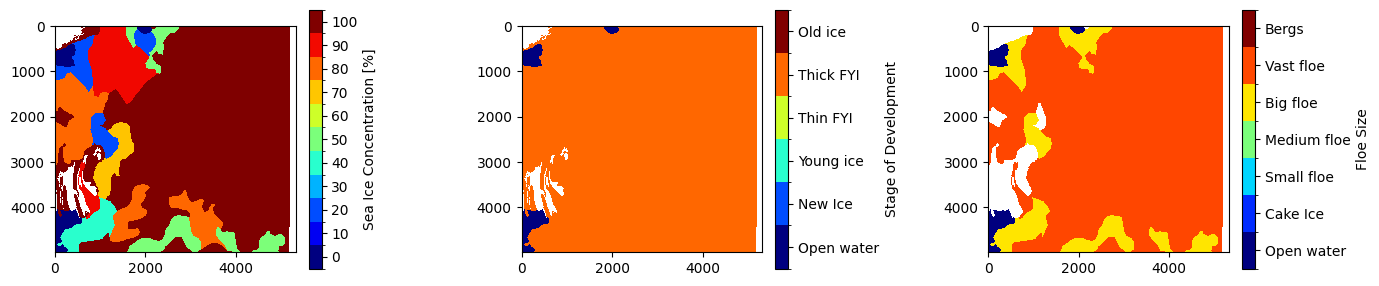

In [36]:
# -- Third-part modules -- #
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np

# --Proprietary modules -- #
from functions import chart_cbar
from utils import CHARTS, GROUP_NAMES, LOOKUP_NAMES, SIC_LOOKUP, SOD_LOOKUP, FLOE_LOOKUP, SCENE_VARIABLES


# - Show charts.
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(12, 8))
for idx, chart in enumerate(CHARTS):
    scene[chart] = scene[chart].astype(float)  # Convert charts from uint8 to float to enable nans in the arrays, 
    # replace chart fill values with nan for better visualization.
    scene[chart].values[scene[chart] == scene[chart].attrs['chart_fill_value']] = np.nan
    axs[idx].imshow(scene[chart].values, vmin=0, vmax=LOOKUP_NAMES[chart]['n_classes'] - 2, cmap='jet', interpolation='nearest')
    chart_cbar(ax=axs[idx], n_classes=LOOKUP_NAMES[chart]['n_classes'], chart=chart, cmap='jet')  # Creates colorbar with ice class names.

plt.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0.75, hspace=0)


Gaps in the reference chart parameters can result from ice polygons either with no information on the parameter or if there is no dominant class meeting the threshold.

# Synthetic Aperture Radar data and auxiliary variables
Sentinel-1 is the radar mission of the Copernicus Earth Observation programme of the European Union (EU). The Sentinel-1 mission comprises a constellation of two polar-orbiting satellites, Sentinel-1A and Sentinel-1B, sharing the same orbital plane and collecting C-band (4.5 cm wavelength) synthetic aperture radar (SAR) images. Radar images can be acquired regardless of the weather. The Sentinel-1 SAR has the advantage of operating at a wavelength not impeded by cloud cover or a lack of illumination, such as in polar darkness, and can acquire data over a site during day or night time under all weather conditions. Since the Arctic area is dominated by cloud cover and polar darkness for a large part of the year, the SAR instrument has for many years been valuable for Arctic monitoring applications such as sea ice charting.
The Sentinel-1 sensor transmits a radar signal towards the ground, and the backscatter is the portion of the outgoing radar signal that the target on the Earth’s surface redirects directly back towards the radar antenna. Some portions of the incident radar signal will be reflected and/or scattered away from the radar or absorbed.

The mode and polarization specifications of the Sentinel-1 images in the sea ice dataset are among those that are traditionally used for ice charting; Sentinel-1 Extra Wide Swath Mode (EW) Level-1 Ground Range Detected products in Medium resolution (GRDM) and in dual polarization, HH and HV. These Sentinel-1 image products cover 400 x 400 square kilometres. A Sentinel-1 image in EW mode consists of five sub-swaths. There are some radiometric variations between these sub-swaths, most evident in HV polarization images. Correcting these differences is a complex task. Other phenomena, such as scalloping effects, are also present in some images. The SAR noise correction in this dataset is provided by the NERSC (Korosov et al., 2021).

It is common practice to visualize SAR data using a grey colourmap. To improve the contrast, 5 and 95% quantiles are used. The incidence angle and distance map are straightforward.

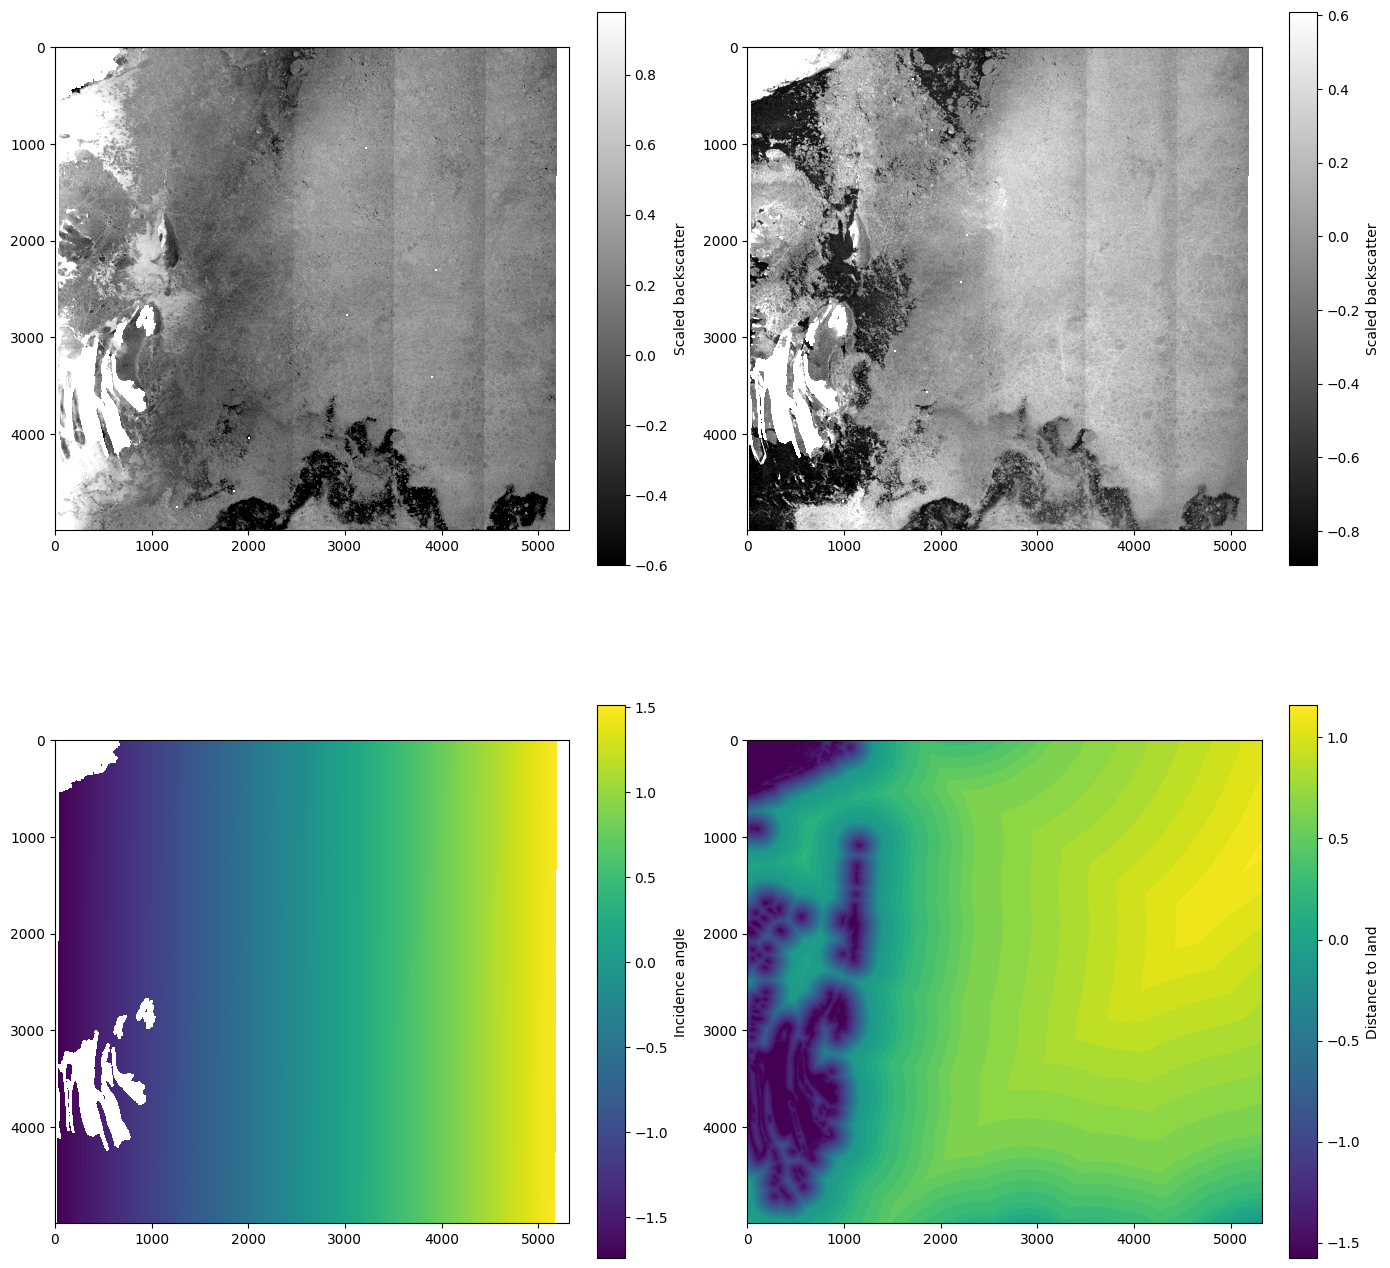

In [9]:
# Show full resolution variables.
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(14,14))
for idx, full_variable in enumerate(SCENE_VARIABLES[0:4]):
    ax = axs[idx // 2, idx % 2]
    if 'nersc_sar' in full_variable:
        scene[full_variable].values[scene[full_variable].values == scene[full_variable].attrs['variable_fill_value']] = np.nan
        label = 'Scaled backscatter'
        im = ax.imshow(scene[full_variable].values, cmap='gray',
                       vmin=np.nanquantile(scene[full_variable].values, q=0.025),
                       vmax=np.nanquantile(scene[full_variable].values, q=0.975))
    elif 'incidenceangle' in full_variable:
        scene[full_variable].values[scene[full_variable].values == scene[full_variable].attrs['variable_fill_value']] = np.nan
        label = 'Incidence angle'
        im = ax.imshow(scene[full_variable].values)
    elif 'map' in full_variable:
        label = 'Distance to land'
        im = ax.imshow(scene[full_variable].values)
    plt.colorbar(im, ax=ax, fraction=0.0485, pad=0.049, label=label)
    
    
fig.tight_layout()

# AMSR2 channels
For each Sentinel-1 scene, a corresponding AMSR2 part of the netCDF file is produced, containing the AMSR2 brightness temperature pixels that are transferred to the Sentinel-1 image geometry. The AMSR2 swaths are resampled to the coordinates of every 50 x 50 (2 km) Sentinel-1 pixel due to the much coarser resolution of the AMSR2 data. Data in the AMSR2 part of the netCDF file are brightness temperatures for each polarization and frequency available from the AMSR2 sensor.  


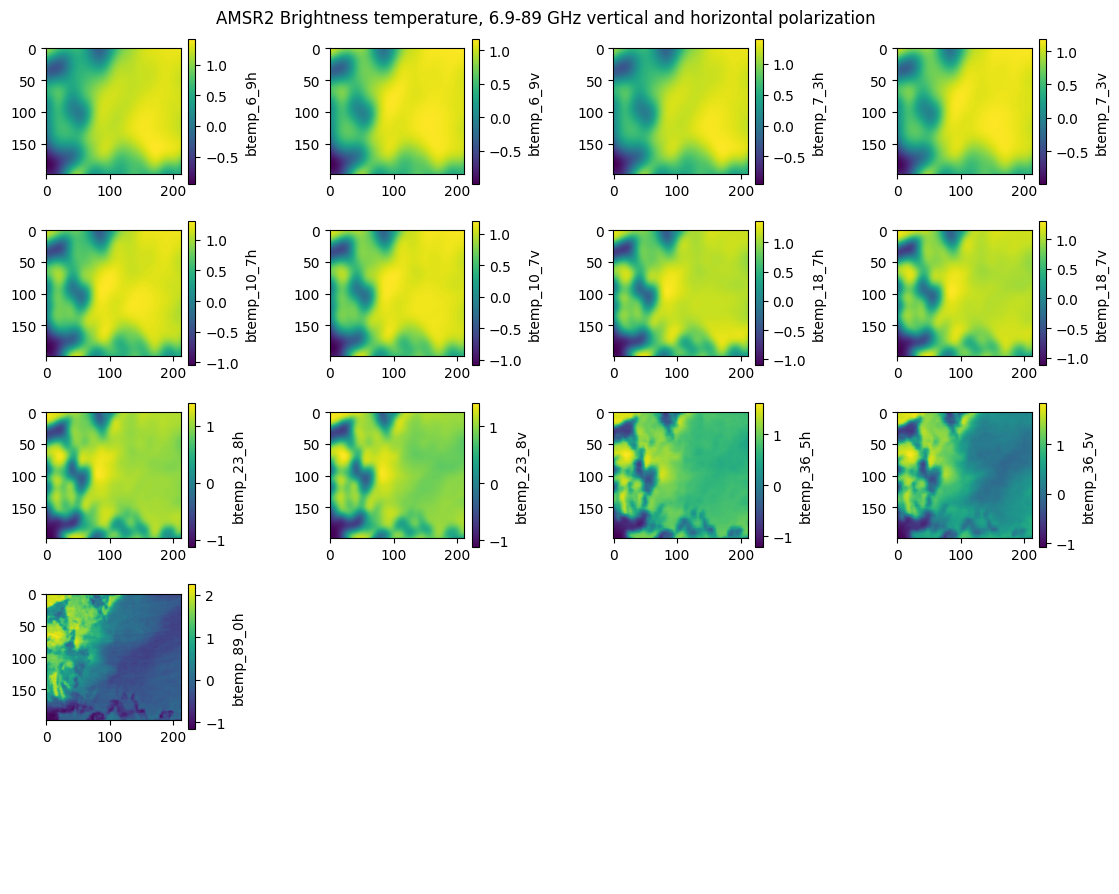

In [10]:



# There is no mask in these scene variables.
fig, axs = plt.subplots(nrows=4, ncols=4, figsize=(10,10))
for idx, amsr2_channel in enumerate(SCENE_VARIABLES[4:17]):
    ax = axs[idx // 4, idx % 4]
    im = ax.imshow(scene[amsr2_channel])
    plt.colorbar(im, ax=ax, fraction=0.0485, pad=0.049, label=amsr2_channel)

fig.suptitle('AMSR2 Brightness temperature, 6.9-89 GHz vertical and horizontal polarization', y=0.875)
[axs[-1, col].axis('off') for col in range(1, 4)]
plt.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0.9, hspace=-0.6)

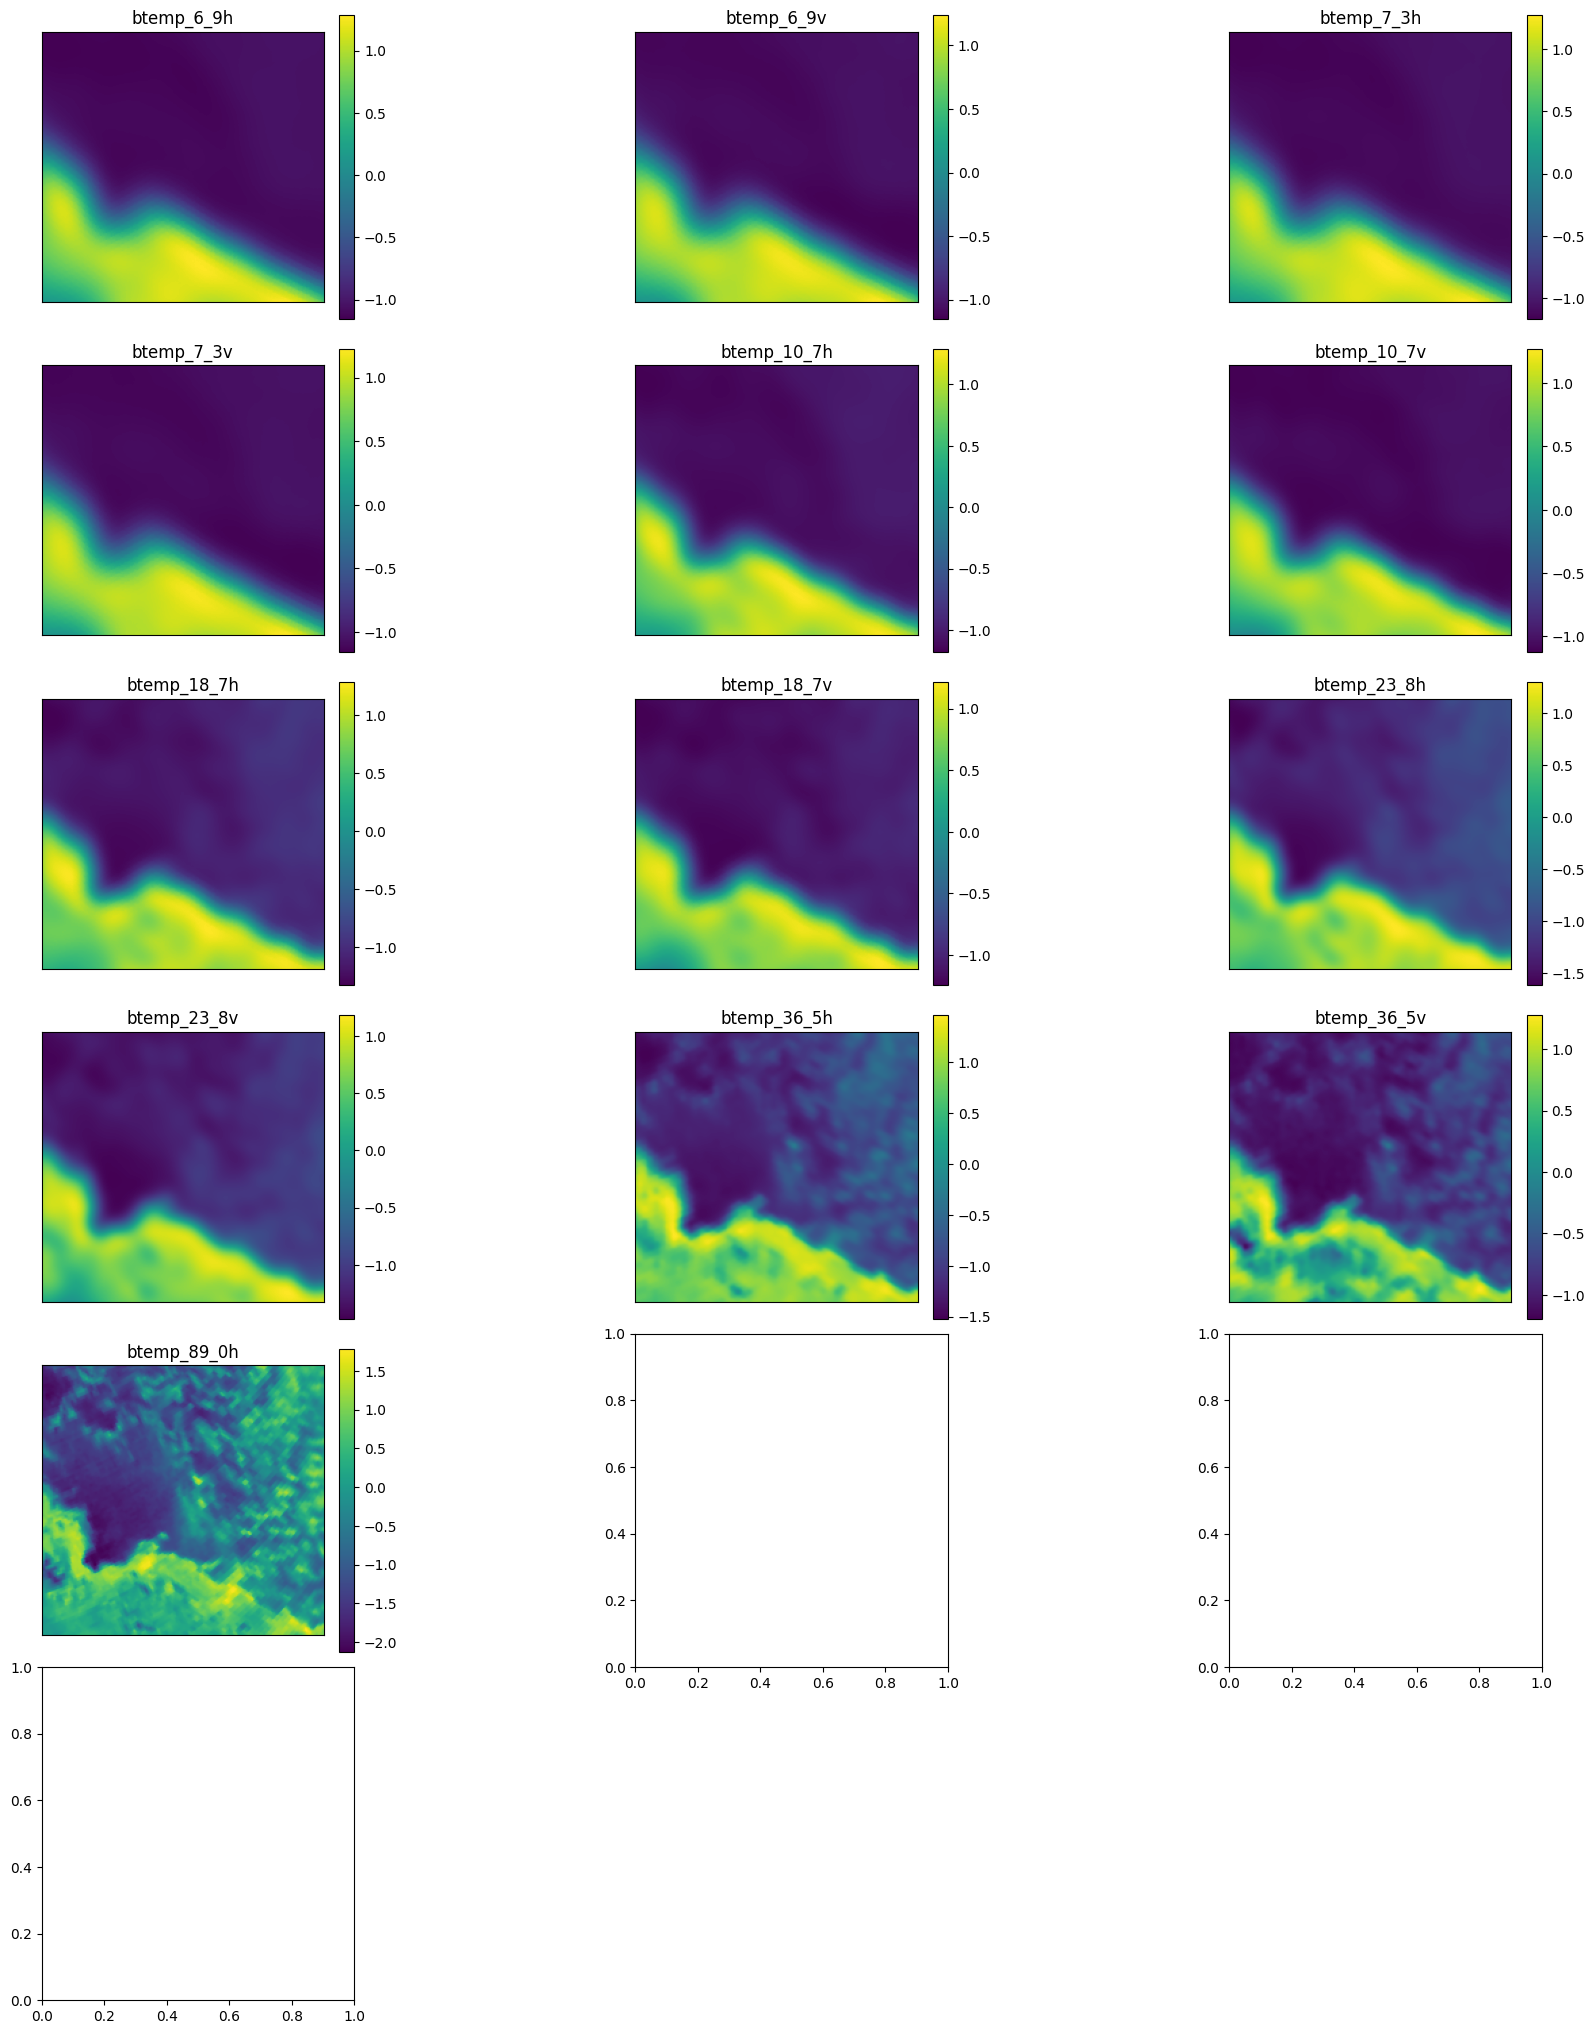

In [7]:
# There is no mask in these scene variables.
fig, axs = plt.subplots(nrows=6, ncols=3, figsize=(10,10))
for idx, amsr2_channel in enumerate(SCENE_VARIABLES[4:17]):
    ax = axs[idx // 3, idx % 3]
    im = ax.imshow(scene[amsr2_channel])
    ax.set_title(amsr2_channel)
    plt.colorbar(im, ax=ax, fraction=0.0485, pad=0.049)
    ax.set_xticks([])  # Remove x-axis tick marks and numbers
    ax.set_yticks([])  # Remove y-axis tick marks and numbers

# fig.suptitle('AMSR2 Brightness temperature, 6.9-89 GHz vertical and horizontal polarization', y=0.875)
[axs[-1, col].axis('off') for col in range(1, 3)]
plt.subplots_adjust(left=0, bottom=0, right=1.5, top=2, wspace=0.9, hspace=-0.0)

#  Environmental variables
For each Sentinel-1 scene, a corresponding ERA5 part of the netCDF file is produced, containing several NWP parameters. These parameters are resampled in the same manner as the AMSR2 brightness temperatures. The ERA5 data is retrieved from the ERA5 hourly data on single levels from 1959 to present reanalysis dataset, which is available at the Copernicus Climate Data Store (cds.climate.copernicus.eu). For each Sentinel-1 scene the NWP parameters with the smallest difference in time to the Sentinel-1 acquisition time are retrieved and resampled to the Sentinel-1 pixels.

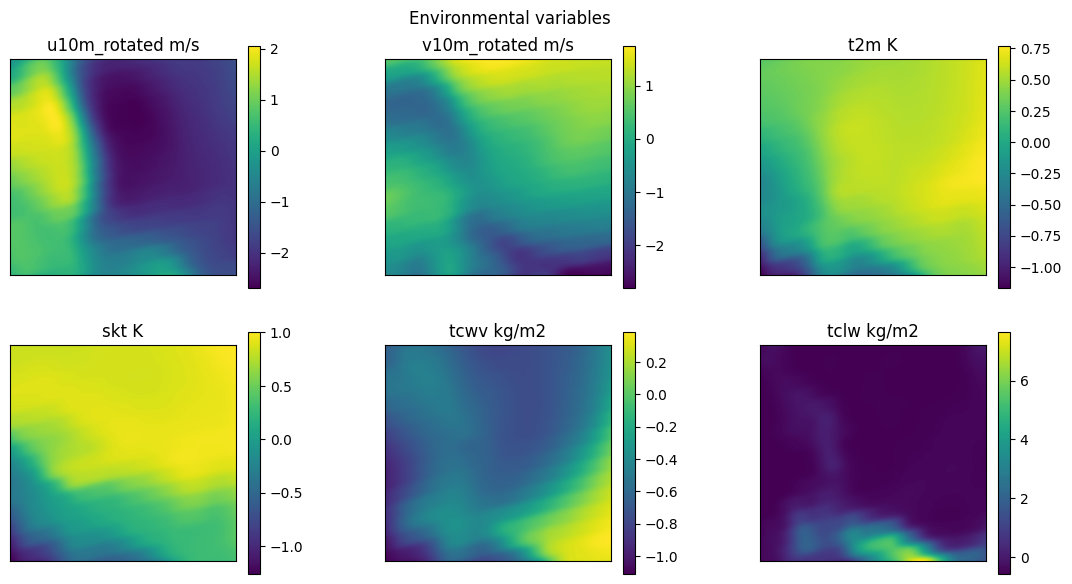

In [10]:
# There is no mask in these scene variables.
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(10,10))
for idx, env_var in enumerate(SCENE_VARIABLES[18:24]):
    ax = axs[idx // 3, idx % 3]
    im = ax.imshow(scene[env_var])
    ax.set_title(env_var + ' ' + scene[env_var].units)
    plt.colorbar(im, ax=ax, fraction=0.0485, pad=0.049)
    ax.set_xticks([])  # Remove x-axis tick marks and numbers
    ax.set_yticks([])  # Remove y-axis tick marks and numbers

fig.suptitle('Environmental variables', y=0.8)
plt.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0.5, hspace=-0.6)

# Data statistics
In the folder 'misc', statistical information regarding the data is available. Class bins for each chart in every (ready-to-train) scene, as well as means, standard deviations, and the minimum and maximum values of the raw challenge dataset.

In [16]:
global_meanstd = np.load(os.environ['AI4ARCTIC_ENV'] + 'misc/global_meanstd.npy', allow_pickle=True).item()
global_minmax = np.load(os.environ['AI4ARCTIC_ENV'] + 'misc/global_minmax.npy', allow_pickle=True).item()

for variable in SCENE_VARIABLES:
    print(f"{variable}; min: {global_minmax[variable]['min']:.3f}, mean: {global_meanstd[variable]['mean']:.3f}, "\
    f"max: {global_minmax[variable]['max']:.3f}, std: {global_meanstd[variable]['std']:.3f}")

TypeError: 'NoneType' object is not subscriptable